In this notebook we build a simple auotencoder for Mnist data, and show how to use it for anomaly detection.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2023-04-05 12:40:11.218750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 12:40:11.520395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-05 12:40:11.520419: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-05 12:40:13.035184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Both the encoder and the decoder are just composed by a couple of dense layers.
The latent dimension is 16. This means that each input is reduced from an initial dimensions of 28*28=784 to a an internal dimension of just 16 floats.

Most of the relevant information is preserved, as testified by the fact that we are able to reconstruct, out of this 16 values, an image very similar to the original one.

In [2]:
# size of our encoded representations
encoding_dim = 16 
mid_dim = 64

# input placeholder
input_img = layers.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(mid_dim, activation='relu')(input_img)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(mid_dim, activation='relu')(encoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

2023-04-05 12:40:30.196244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-05 12:40:30.196356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (andrea): /proc/driver/nvidia/version does not exist
2023-04-05 12:40:30.197208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dense_3 (Dense)             (None, 784)               50960     
                                                                 
Total params: 103,328
Trainable params: 103,328
Non-trainable params: 0
_________________________________________________________________


We can now compile the model. 

As loss function we can take mse or categorical crossentropy, as you prefer. 

In [4]:
adam = Adam(lr=0.001)
autoencoder.compile(optimizer=adam, loss='mse')

We now load the datatet, and normalize it in the range [0,1]. We are not using labels.

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Time to fit the model. Observe that the ground truth we need to compare with is in this case the input itself. In other words, the loss is the distance between the inout $X$ and its reconstruction $\hat{X}$

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

2023-04-05 12:40:59.981873: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2023-04-05 12:41:00.293018: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/20
235/235 [==============================] - 5s 15ms/step - loss: 0.0711 - val_loss: 0.0439
Epoch 2/20
235/235 [==============================] - 2s 8ms/step - loss: 0.0384 - val_loss: 0.0336
Epoch 3/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0324 - val_loss: 0.0303
Epoch 4/20
235/235 [==============================] - 3s 12ms/step - loss: 0.0289 - val_loss: 0.0268
Epoch 5/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0264 - val_loss: 0.0253
Epoch 6/20
235/235 [==============================] - 2s 9ms/step - loss: 0.0254 - val_loss: 0.0246
Epoch 7/20
235/235 [==============================] - 2s 10ms/step - loss: 0.0248 - val_loss: 0.0240
Epoch 8/20
235/235 [==============================] - 3s 12ms/step - loss: 0.0243 - val_loss: 0.0237
Epoch 9/20
235/235 [==============================] - 3s 13ms/step - loss: 0.0239 - val_loss: 0.0233
Epoch 10/20
235/235 [==============================] - 3s 14ms/step - loss: 0.0236 - val_loss

Let us check the result.

First of all we conpute all reconstructions for images in the test set.

In [7]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 4ms/step


Now we can plot the result. We pick ten random images, and for each of them we show the original and the reconstruction obtained from the autoencoder.

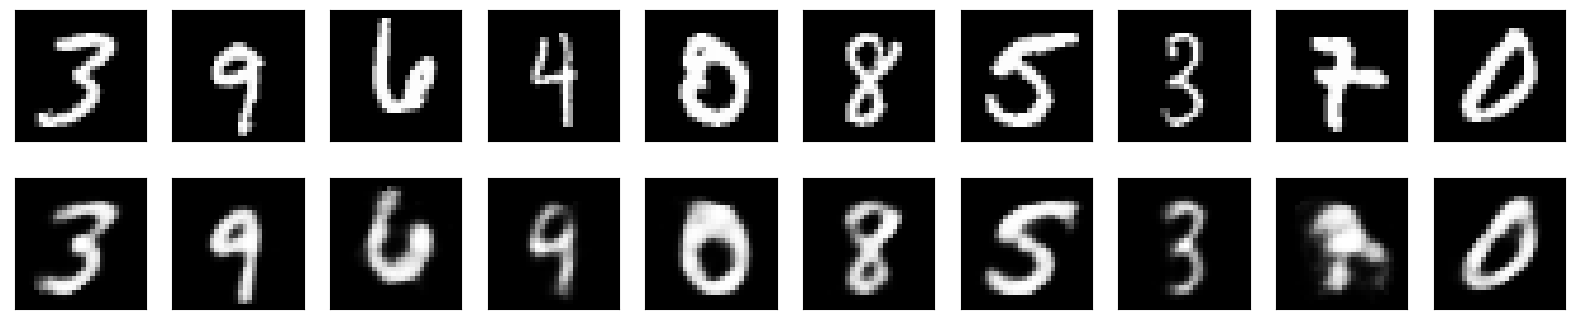

In [8]:
import matplotlib.pyplot as plt

n = 10 #no images to plot
imgs = np.random.randint(low=0,high=10000,size=n)
plt.figure(figsize=(20, 4))
for (i,idx) in enumerate(imgs):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idx].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Anomaly detection

We want now to show how we can use an autoencoder for anomaly detection.

The genral idea is that the encoding learned by the autoenoder is data-specific. This means that if we apply the autoencoder to an outlier, the resulting reconstruction should be sensibily worse than usual, and we may exploit this simple fact to detect the anomaly.

The first step of the procedure is to identify the canonical expected reconstruction error on true data, and the associated standard deviation.

In [10]:
mse_all = np.mean(np.square(decoded_imgs - x_test),axis=1) #mean error for each input
print(mse_all.shape) 
mse = np.mean(mse_all)
std = np.std(mse_all)
print("mse is {}, with a standard deviation of {}".format(mse,std))

(10000,)
mse is 0.019202498719096184, with a standard deviation of 0.010214189998805523


Now we create an "anomaly". We simply take a normal image from the dataset, and rotate it of 90 degrees. 

For this example, we use image no 15 in the test set.

1/1 [==============================] - 0s 79ms/step - loss: 0.0267
0.026665130630135536


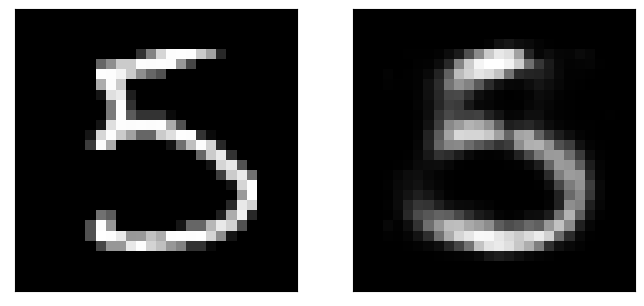

In [12]:
test = x_test[15].reshape(1,784)
print(autoencoder.evaluate(test,test))

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(x_test[15].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(decoded_imgs[15].reshape(28, 28))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# plt.savefig('lyar1.jpg')
plt.show()

Observe that the reconstruction is not particularly good, but still the loss (0.207) is more or less on std away from the mean, that is a normal behaviour.

Now, let us rotate it and repeat the computation.

1/1 [==============================] - 0s 65ms/step


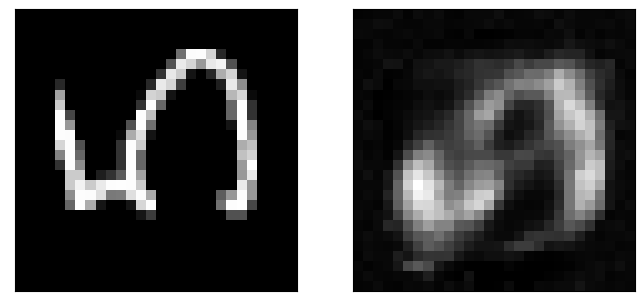

In [13]:
rotated = np.rot90(x_test[15].reshape(28,28))
predicted = autoencoder.predict(rotated.reshape(1,784))[0].reshape(28,28)

plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
plt.imshow(rotated)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# plt.savefig('lyar2.jpg')
plt.show()

In [14]:
mse = np.mean(np.square(predicted-rotated))
print("mse is {}".format(mse))

mse is 0.05138840898871422


The mse in this case is 0.052, more than 3 std away form the mean, that is surely an anomaly!!

Let us finally observe that, instead of using mean and variance of reconstruction errors, we could have directly worked in the latent space.

In fact, autoencoders generalize Principal Component Ananlysis, extracting relevant, non linear combinations of the input features. Any anomaly will 
sensibibly discost from canonical values of the latent encoding.